# 00-basic-watershed-seg.ipynb
This notebook is similar continues the segmentation procedure outline in `README.md`, with a different step for determing the local maxima. 
Steps performed here include:
- Load data
- Binarize images
- Save binarized images
- Segment images
- Save segmented images

Note: `napari` is recommended as an image viewer since it opens the image in a separate window and allows subsequently loaded images to be seen as layers above other images. However, if you are having trouble installing `napari` (there are known issues with the dependency `VisPy` on some new MacBooks), or if you would rather not use `napari` for some other reason, a cell is included that shows how to view images using `matplotlib.pyplot` instead. This can be extrapolated to all cells utilizing `napari`.

# Import packages

In [41]:
# Standard library imports
from pathlib import Path
# Third-party imports
import imagecodecs  # dependency required for loading compressed tif images
import imageio as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from scipy import ndimage as ndi
from skimage import (
    color, feature, filters, measure, segmentation, util
)

# Load data

In [19]:
# open napari viewer
viewer = napari.Viewer()

In [16]:
project_dir = Path('.').resolve()
print(project_dir)

C:\Users\gusb\Research\mhe-analysis\ct-segment-python


In [17]:
img_path_list = [
    path for path in Path(project_dir / 'example-imgs').glob('*.tif')
]
len(img_path_list)

10

In [23]:
imgs = [
    util.img_as_float(  # Convert image to floating point image
        iio.imread(img_path)  # Load image as numpy array
    ) 
    for img_path in img_path_list
]
print(f'{imgs[0].shape=}')
print(f'{imgs[0].dtype=}')

imgs[0].shape=(1004, 924)
imgs[0].dtype=dtype('float64')


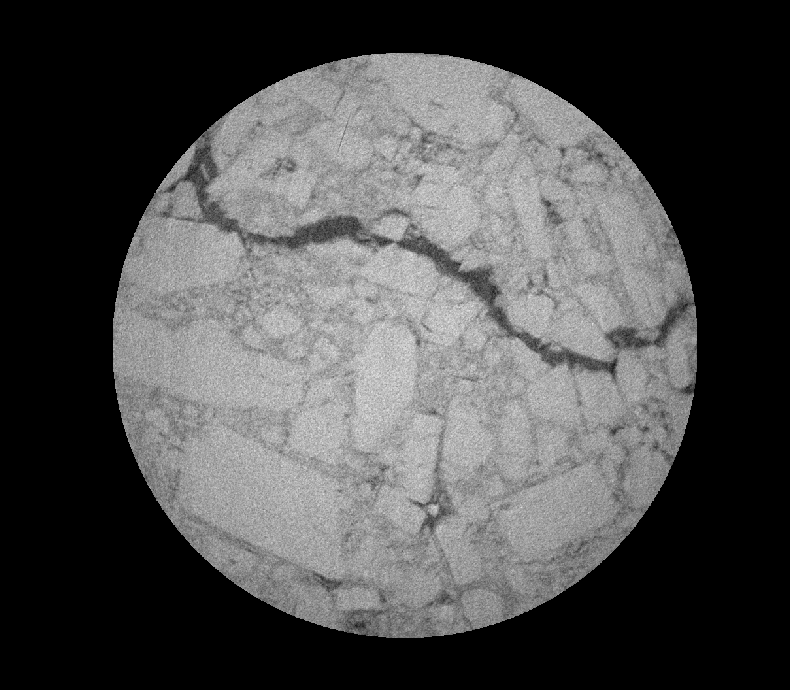

In [25]:
# Add list of images (converted to array of images) to napari viewer
viewer.add_image(np.array(imgs), name='raw data')
# Show screenshot of napari viewer canvas
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Alternate method for displaying images without `napari`

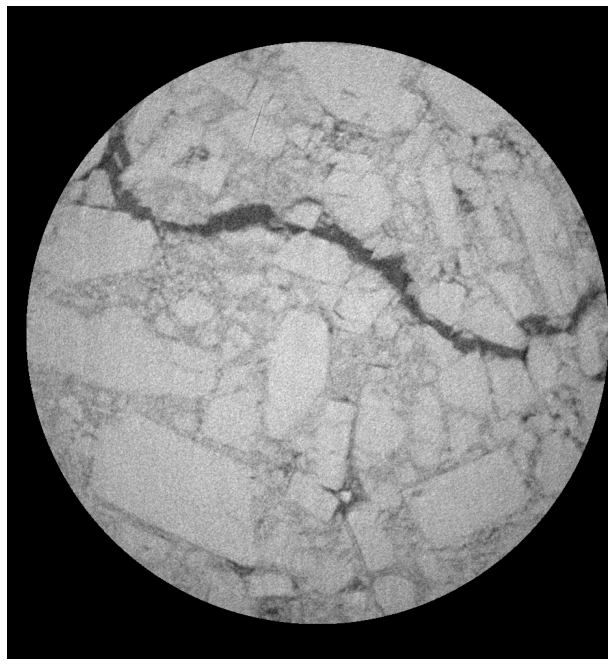

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(imgs[0], cmap='gray')
ax.axis('off')
plt.show()

# Binarize images

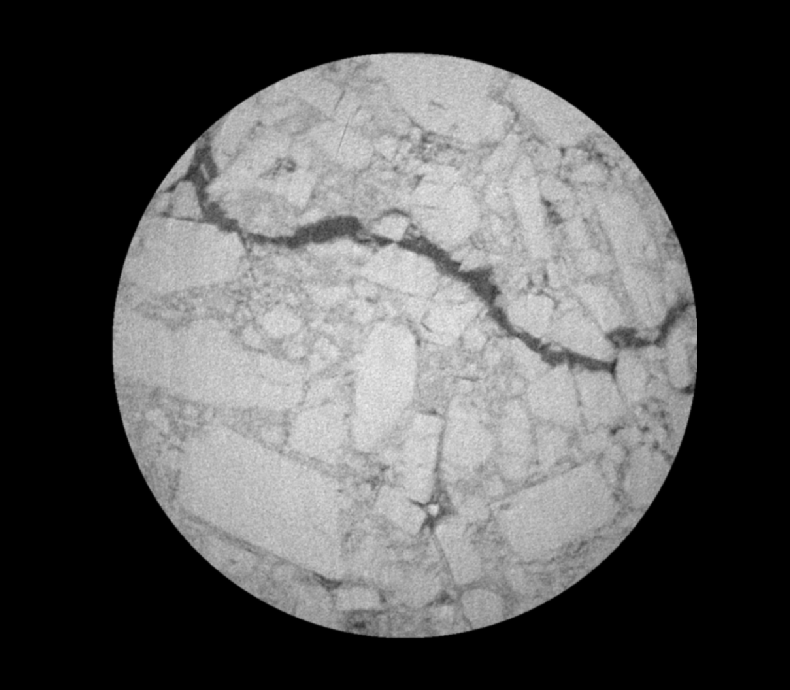

In [34]:
smooth_imgs = [filters.gaussian(img) for img in imgs]
viewer.add_image(np.array(smooth_imgs), name='smoothed')
napari.utils.nbscreenshot(viewer, canvas_only=True)

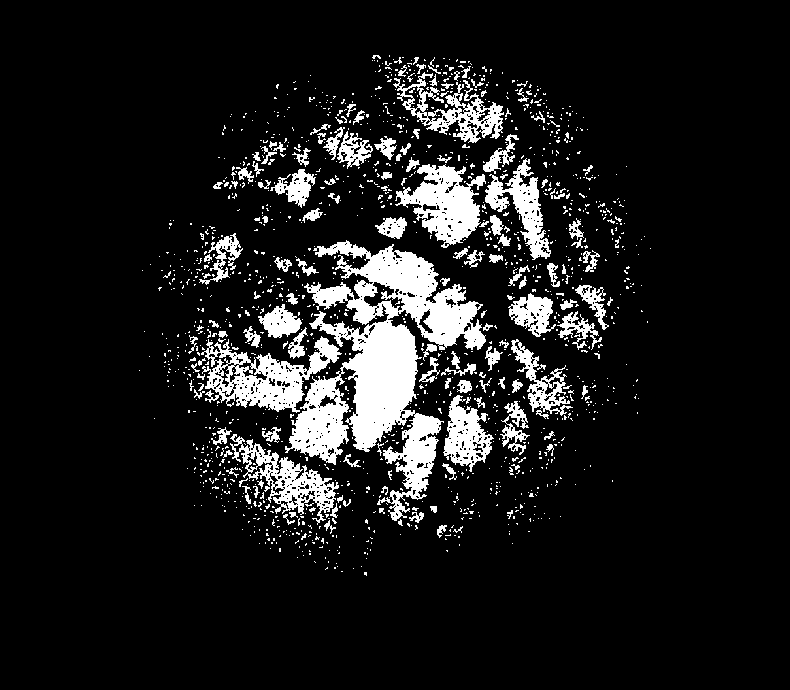

In [40]:
thresh_val = 0.65
binary_imgs = [img > thresh_val for img in smooth_imgs]
viewer.add_image(np.array(binary_imgs), name=f'thresholded: >{thresh_val}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Save binary images

In [105]:
save_binary = False

# Directory location to save images
save_dir = Path(project_dir / 'binary-imgs')
# Create directory, or raise an error if that directory already exists
save_dir.mkdir(parents=True, exist_ok=False)

if save_binary:
    for i, img in enumerate(binary_imgs):
        img = util.img_as_ubyte(img)
        iio.imsave(
            Path(save_dir / f'binary-img-{str(i).zfill(3)}.tif'), img
        )

# Create distance map from binary images

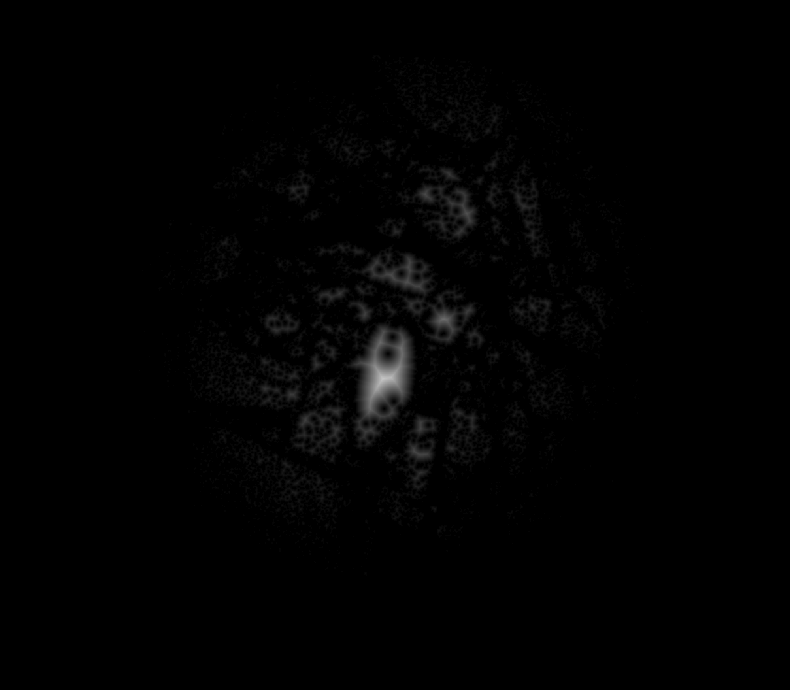

In [43]:
dist_maps = [ndi.distance_transform_edt(img) for img in binary_imgs]
viewer.add_image(np.array(dist_maps), name=f'distance maps')
napari.utils.nbscreenshot(viewer, canvas_only=True)

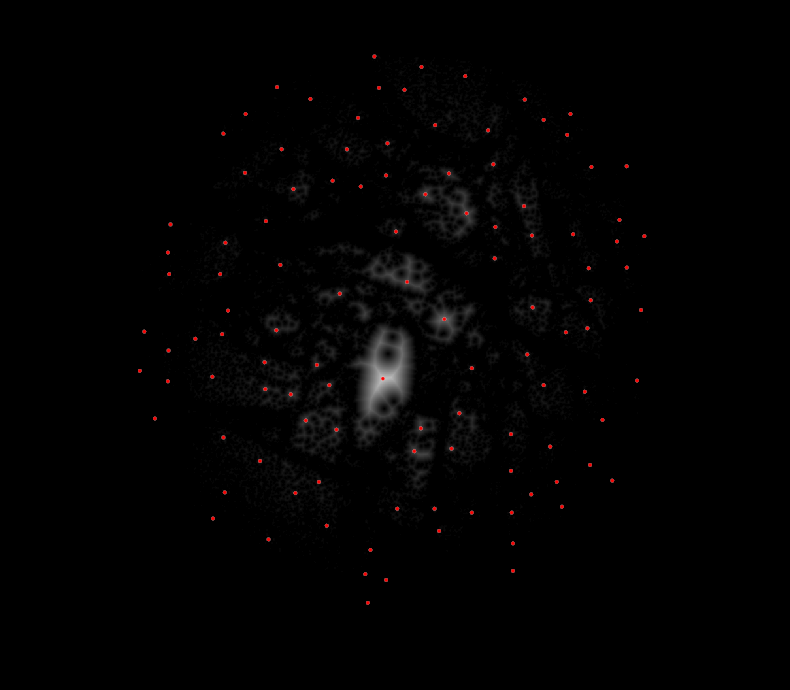

In [82]:
maxima_list = []
seeds_list = []
min_distance = 30
for i, img in enumerate(dist_maps):
    # Get Nx2 array of N number of (row, col) coordinates
    maxima_r_c = feature.peak_local_max(img, min_distance=min_distance)
    # Insert a column with the slice number i to make the array Nx3 
    maxima_slice_r_c = np.insert(maxima_r_c, 0, i, axis=1)
    # Add Nx3 array of points with slice number to the maxima_list
    maxima_list.append(maxima_slice_r_c)
    # Assign a label to each point to use as seed for watershed seg
    mask = np.zeros_like(img, dtype=bool)
    mask[tuple(maxima_r_c.T)] = 1
    seeds = measure.label(mask)
    seeds_list.append(seeds)
# Concatenate list of arrays into a single array along the row dim (axis = 0)
maxima_points = np.concatenate(maxima_list, axis=0)
viewer.add_points(
    maxima_points, name='local maxima', size=5, face_color='red', 
    edge_color='transparent'
)
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Watershed segmentation seeded with distance map peaks

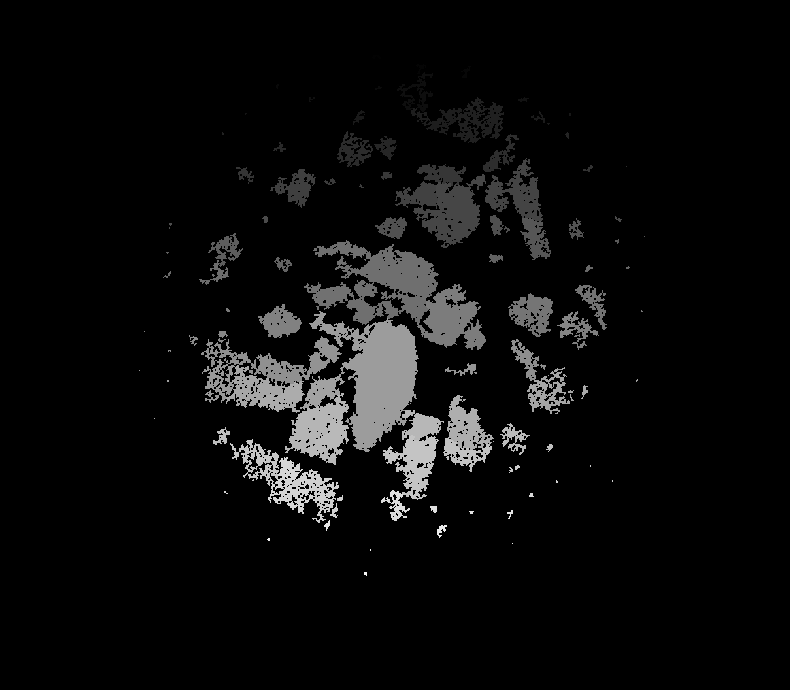

In [90]:
seg_labels_list = [
    segmentation.watershed(-img, seeds, mask=mask) 
    for img, seeds, mask in zip(dist_maps, seeds_list, binary_imgs)
]
viewer.add_image(np.array(seg_labels_list), name=f'watershed seg.')
napari.utils.nbscreenshot(viewer, canvas_only=True)

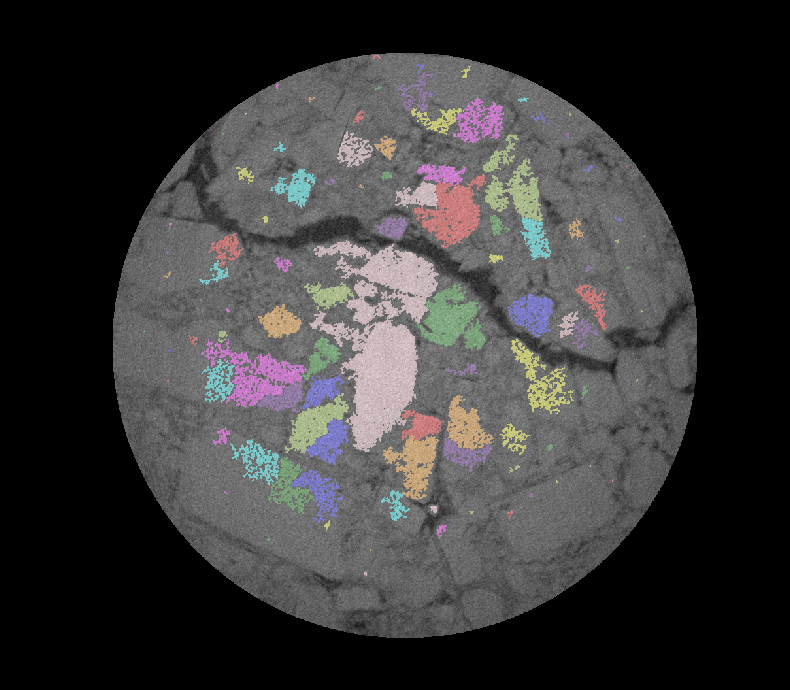

In [97]:
rgb_seg_labels_list = [
    color.label2rgb(
        seg_labels, image=img, 
        # colors=[
        #     (42, 157, 143), (233, 196, 106), (244, 162, 97), (231, 111, 81)
        # ],
         bg_label=0
    ) for seg_labels, img in zip(seg_labels_list, imgs)
]
viewer.add_image(np.array(rgb_seg_labels_list), name=f'seg. overlay')
napari.utils.nbscreenshot(viewer, canvas_only=True)